## Acquire data

In [3]:
# Set your data rootdirectory, or have it be chosen for you!

data_rootdir = ''

if not data_rootdir:
    from imbed.util import DFLT_SAVES_DIR, process_path

    data_rootdir = process_path(
        DFLT_SAVES_DIR, 'epstein_files', ensure_dir_exists=True
    )


import os

if not os.path.isdir(data_rootdir):
    raise FileExistsError("The directory wasn't found: {data_rootdir}")




In [79]:
# tell us where you downloaded the db file -- if not, we'll download it for you and put it in the data_rootdir
# sqlite_db_file = '/Users/thorwhalen/Dropbox/py/misc/Epstein-doc-explorer/document_analysis.db'
sqlite_db_file = None

In [80]:
from imbed_data_prep.epstein_files import acquire_epstein_data

acquire_epstein_data( 
    out_dir=data_rootdir,
    sqlite_db_file=sqlite_db_file,
)

DuckDB: connecting (export -> /Users/thorwhalen/Dropbox/_odata/app_data/imbed/saves/epstein_files)
DuckDB: installing/loading sqlite_scanner extension...
DuckDB: attaching SQLite db as schema 'src'...
Tables discovered: ['canonical_entities', 'documents', 'entity_aliases', 'rdf_triples', 'sqlite_sequence', 'tag_embeddings']
Exporting src.canonical_entities -> /Users/thorwhalen/Dropbox/_odata/app_data/imbed/saves/epstein_files/canonical_entities.parquet
Exporting src.documents -> /Users/thorwhalen/Dropbox/_odata/app_data/imbed/saves/epstein_files/documents.parquet
Exporting src.entity_aliases -> /Users/thorwhalen/Dropbox/_odata/app_data/imbed/saves/epstein_files/entity_aliases.parquet
Exporting src.rdf_triples -> /Users/thorwhalen/Dropbox/_odata/app_data/imbed/saves/epstein_files/rdf_triples.parquet
Exporting src.sqlite_sequence -> /Users/thorwhalen/Dropbox/_odata/app_data/imbed/saves/epstein_files/sqlite_sequence.parquet
Exporting src.tag_embeddings -> /Users/thorwhalen/Dropbox/_odata/

PosixPath('/Users/thorwhalen/Dropbox/_odata/app_data/imbed/saves/epstein_files')

## Kicking the data around

In [ ]:
import dol 
import tabled

wrapper = dol.Pipe(
    dol.filt_iter(filt=lambda k: k.endswith('.parquet')),
    dol.wrap_kvs(key_codec=dol.KeyCodecs.suffixed('.parquet')),
)

tables = wrapper(tabled.DfFiles(data_rootdir))

# tabled.dataframe_info(s)
list(tables)

### What info fields does `tabled.dataframe_info` give us?

In [ ]:
print(*tabled.dataframe_info(tables['rdf_triples']), sep=', ')

shape, columns, first_row, sample_rows, numeric_stats, categorical_stats


### Compute various info stores

In [ ]:
from typing import Literal, get_args

import operator 

InfoKeys = Literal['shape', 'columns', 'first_row', 'sample_rows', 'numeric_stats', 'categorical_stats']

def make_info_store(*info_keys: InfoKeys):
    return dol.wrap_kvs(
        tables, 
        value_decoder=dol.Pipe(tabled.dataframe_info, operator.itemgetter(  # choose info to grab, from 
            *info_keys
        )),
        
    )

all_info = make_info_store(*get_args(InfoKeys))
columns_info = make_info_store('columns')
shape_info = make_info_store('shape')
numeric_info = make_info_store('numeric_stats')
categorical_info = make_info_store('categorical_stats')


### Peep at the shapes of the tables

In [ ]:
dict(shape_info)

{'rdf_triples': (107030, 14),
 'documents': (25232, 17),
 'relationships_edges': (107030, 12),
 'entity_aliases': (28934, 6),
 'sqlite_sequence': (2, 2),
 'tag_embeddings': (29689, 4),
 'canonical_entities': (26690, 3)}


### Peep at the columns of the tables

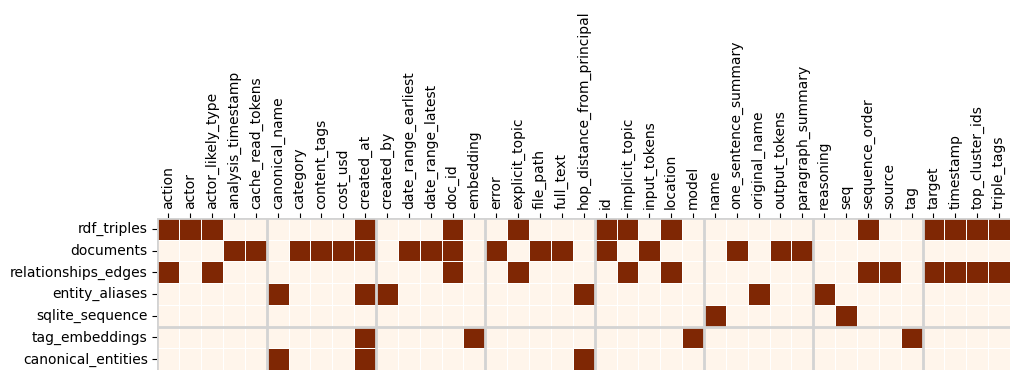

In [10]:
def view_tables_and_their_columns(columns_info: dict) -> dict[str, list[str]]:
    """
    make and view a heatmap of a table of tables_and_their_columns where rows are 
    the keys and columns columns are the union of the strings in their lists
    and value of cells are 1 if the column is present in the table, else 0
    """
    import pandas as pd
    from oplot.matrix import heatmap_sns  # pip install oplot

    all_columns = set()
    for cols in columns_info.values():
        all_columns.update(cols)    
    all_columns = sorted(all_columns)
    heatmap_data = pd.DataFrame(0, index=columns_info.keys(), columns=all_columns)
    for table, cols in columns_info.items():
        for col in cols:
            heatmap_data.at[table, col] = 1

    return heatmap_sns(heatmap_data)

view_tables_and_their_columns(columns_info)

### Have a look at some tables

In [74]:
print(f"{tables['documents'].shape}")
print(tables['documents'].iloc[0].to_string())

(25232, 17)
id                                                                      1
doc_id                                             HOUSE_OVERSIGHT_010477
file_path                       data/001_split/HOUSE_OVERSIGHT_010477.txt
one_sentence_summary    A heavily illustrated book excerpt and photo c...
paragraph_summary       This document is an excerpt from a book about ...
date_range_earliest                                                  1969
date_range_latest                                                 2016-01
category                                                     book_excerpt
content_tags            ["biographical_documentation","photography_and...
analysis_timestamp                               2025-11-14T06:38:19.665Z
input_tokens                                                          3.0
output_tokens                                                      2988.0
cache_read_tokens                                                 18280.0
cost_usd                  

In [72]:
print(tables['documents'].iloc[0].one_sentence_summary)

print(tables['documents'].iloc[0].paragraph_summary)
len(tables['documents'].iloc[0].full_text)

A heavily illustrated book excerpt and photo collection from a biography of Jeffrey Epstein, documenting his properties, associates, legal proceedings, and lifestyle from the 1960s through 2016.
This document is an excerpt from a book about Jeffrey Epstein's life and criminal history, titled 'The Powerful Billionaire, the Ex Scandal That Undid Him, and All the Justice That Money Can Buy: The Shocking True Story of Jeffrey Epstein.' The document contains photographs and captions spanning from Epstein's 1969 high school yearbook through 2016, documenting his properties (Palm Beach, Manhattan townhouse, Little Saint James island in the U.S. Virgin Islands), his associates and social connections (Leslie Wexner, Ghislaine Maxwell, Donald Trump, Prince Andrew, Stephen Hawking, and others), his legal troubles and conviction, his jail sentence at Palm Beach County Stockade, and his Gulfstream aircraft. The document tracks key events including his 2005 criminal investigation beginning, his 2008

9376

In [55]:
print(f"{tables['relationships_edges'].shape}")
tables['relationships_edges'].iloc[0]

(107030, 12)


source                                                 Jeffrey Epstein
target                                  Lafayette High School yearbook
action                                                 photographed in
timestamp                                                          NaN
location                                                           NaN
doc_id                                          HOUSE_OVERSIGHT_010477
sequence_order                                                       0
actor_likely_type                                                  NaN
triple_tags          ["biographical_photo","high_school","identity_...
explicit_topic                              biographical documentation
implicit_topic                                   early life background
top_cluster_ids                                             [16,26,27]
Name: 0, dtype: object

In [61]:
print(f"{tables['tag_embeddings'].shape}")
tables['tag_embeddings'].iloc[0]

(29689, 4)


tag                                         email_communication
embedding     [0.02476835877039858,-0.009844271982040728,-0....
model                        Qwen3-Embedding-0.6B-ONNX-fp16-32d
created_at                                  2025-11-16 07:37:48
Name: 0, dtype: str

In [ ]:
print(f"tags are unique: {tables['tag_embeddings'].tag.nunique() == len(tables['tag_embeddings'])}")


tags are unique: True


In [62]:
len(tables['tag_embeddings'].iloc[0]['embedding'])


663

In [77]:
tables['test'] = tables['tag_embeddings'].iloc[:10]

### Get some stats about all the tables

In [60]:
import lkj
from pprint import pformat

# Even more informative version that shows statistics
def comprehensive_handle_special_types(obj):
    """Most informative while still being manageable"""
    
    # Check if it's a pandas DataFrame
    if hasattr(obj, 'columns') and hasattr(obj, 'index') and hasattr(obj, 'shape'):
        try:
            rows, cols = obj.shape
            col_names = list(obj.columns)
            if cols <= 6:
                col_display = col_names
            else:
                col_display = col_names[:4] + ['...'] + col_names[-1:]
            return f"<DataFrame({rows}x{cols}): {col_display}>"
        except:
            return f"<DataFrame>"
    
    # Check if it's a pandas Series
    elif hasattr(obj, 'head') and hasattr(obj, 'dtype') and hasattr(obj, 'index'):
        try:
            length = len(obj)
            dtype = str(obj.dtype)
            
            # For small series, show more
            if length <= 6:
                values = obj.tolist()
                return f"<Series[{dtype}]({length}): {values}>"
            
            # Check if it looks like value_counts results (has count/frequency pattern)
            if hasattr(obj, 'index') and len(obj) > 10:
                head_items = obj.head(2)
                tail_items = obj.tail(1)
                index_sample = head_items.index.tolist()
                values_sample = head_items.tolist()
                
                if dtype in ['int64', 'int32'] and all(isinstance(v, (int, float)) for v in values_sample):
                    # Looks like value counts
                    total = obj.sum() if hasattr(obj, 'sum') else 'unknown'
                    return f"<ValueCounts[{length} categories, total={total}]: top={list(zip(index_sample, values_sample))}>"
                else:
                    return f"<Series[{dtype}]({length}): idx={index_sample}, vals={values_sample}...>"
            
            # Regular series handling
            head_vals = obj.head(3).tolist()
            
            if dtype == 'object':
                try:
                    unique_count = obj.nunique()
                    return f"<Series[{dtype}]({length}, {unique_count} unique): {head_vals}...>"
                except:
                    return f"<Series[{dtype}]({length}): {head_vals}...>"
            
            return f"<Series[{dtype}]({length}): {head_vals}...>"
        except Exception as e:
            return f"<Series[error: {str(e)[:50]}]>"
    
    # Check if it's a numpy array 
    elif hasattr(obj, 'shape') and hasattr(obj, 'dtype'):
        try:
            shape = obj.shape
            dtype = str(obj.dtype)
            size = obj.size
            
            if size <= 8:
                return f"<Array[{dtype}]{shape}: {obj.tolist()}>"
            else:
                flat = obj.flatten()
                sample = flat[:4].tolist()
                return f"<Array[{dtype}]{shape}({size}): {sample}...>"
        except:
            return f"<Array>"
    
    return obj



# Test comprehensive version
print("Testing comprehensive handle_special_types...")
result = lkj.truncate_dict_values(
    dict(all_info), 
    d_ingress=comprehensive_handle_special_types,
    max_list_size=5,
    max_string_size=150
)

string = pformat(result)
print(string)

Testing comprehensive handle_special_types...
{'canonical_entities': ((26690, 3),
                        ['canonical_name',
                         'hop_distance_from_principal',
                         'created_at'],
                        '<Series[object](3): [\'"I\\\'m like a Heidi '
                        'Fleiss"\', np.int64(2), \'2025-11-18 15:17:38\']>',
                        "<DataFrame(3x3): ['canonical_name', "
                        "'hop_distance_from_principal', 'created_at']>",
                        "<DataFrame(8x1): ['hop_distance_from_principal']>"),
 'documents': ((25232, 17),
               ['id',
                'doc_id',
                'file_path',
                'one_sentence_summary',
                'paragraph_summary'],
               "<Series[object](17): idx=['id', 'doc_id'], vals=[np.int64(1), "
               "'HOUSE_OVERSIGHT_010477']...>",
               "<DataFrame(3x17): ['id', 'doc_id', 'file_path', "
               "'one_sentence_summary', 

## Prepare data for Cosmograph

In [4]:
from imbed_data_prep.epstein_files import prepare_cosmograph_data

cosmo_data = prepare_cosmograph_data(data_dir=data_rootdir)
points = cosmo_data['points']
links = cosmo_data['links']

print(f"Points: {points.shape}, Links: {links.shape}")
points.head(10)

Reading parquet files from /Users/thorwhalen/Dropbox/_odata/app_data/imbed/saves/epstein_files
Resolving entity aliases...
Deduplicating edges...
  65467 unique directed edges
Building nodes...
  55880 nodes (26690 with hop distance, 29190 without)
Done.
Points: (55880, 3), Links: (65467, 13)


,canonical_name,degree,hop_distance
0,Jeffrey Epstein,6494,0.0
1,unknown person A,4144,NaN
2,Donald Trump,1728,1.0
3,Alan M. Dershowitz,898,1.0
4,Edward Snowden,763,2.0
5,Ehud Barak,743,1.0
6,unknown person B,508,NaN
7,Steve Bannon,428,1.0
8,Barack Obama,402,1.0
9,Bank of America Merrill Lynch,378,2.0


In [11]:
print(f"{points.shape}")
points.iloc[2]

(55880, 3)


canonical_name    Donald Trump
degree                    1728
hop_distance               1.0
Name: 2, dtype: object

In [12]:
print(f"{links.shape}")
links.iloc[0]

(65467, 13)


source                                                 Jeffrey Epstein
target                                  Lafayette High School yearbook
weight                                                               1
action                                                 photographed in
timestamp                                                          NaN
location                                                           NaN
doc_id                                          HOUSE_OVERSIGHT_010477
sequence_order                                                       0
actor_likely_type                                                  NaN
triple_tags          ["biographical_photo","high_school","identity_...
explicit_topic                              biographical documentation
implicit_topic                                   early life background
top_cluster_ids                                             [16,26,27]
Name: 0, dtype: object

In [ ]:
# save points and links as epstein_points_02.parquet and epstein_links_02.parquet
points.to_parquet(os.path.join(data_rootdir, 'epstein_points_02.parquet'))
links.to_parquet(os.path.join(data_rootdir, 'epstein_links_02.parquet'))
print(data_rootdir)

/Users/thorwhalen/Dropbox/_odata/app_data/imbed/saves/epstein_files


In [15]:
from cosmograph import cosmo 

cosmo(
    points=points,
    links=links,

    point_id_by="canonical_name",
    point_color_by="hop_distance",
    # point_color_strategy="interpolate",
    point_size_by="degree",
    point_size_scale=0.8,
    point_label_by="canonical_name",

    link_source_by="source",
    link_target_by="target",
    link_color_by="action",
    link_arrows=True,
    link_width_by="weight",

    show_dynamic_labels=True,
)

Cosmograph(background_color=None, components_display_state_mode=None, focused_point_ring_color=None, hovered_p…

In [1]:
# cosmo(
#     data=tables['merged_artifacts'],

#     point_x_by="x",
#     point_y_by="y",

#     point_color_by="cluster_13",
#     point_color_strategy="palette",
#     point_cluster_by="cluster_13",

#     point_label_by="title",
#     point_size_by="n_tokens",

#     show_dynamic_labels=True,
# )

# Planarize topic embeddings